In [ ]:
% check x-y directionctsn probably the other way around 

In [230]:
using StatsBase

In [566]:
function give_grid_posistion(grid,(x,y))
    return length(grid[:,1])*(x-1) + y
end

function give_cartisian_posistion(grid,pos)
    l1=length(grid[:,1])
    y= (pos-1) %l1
    y+= 1
    x=floor(Int,(pos-y) /l1 ) +1
    return x,y
end

give_cartisian_posistion (generic function with 1 method)

In [569]:
start=(4,5)
point=give_grid_posistion(testgrid.grid,start)
point,give_cartisian_posistion(testgrid.grid,point)

(35, (4, 5))

In [565]:
point

30

In [628]:
function build_pickle_grid(size,holes,thick,basevalue)
    pickle=convert.(Int8,ones(Int8,size).*basevalue)
    pickle[1,:].=0
    pickle[size[1],:].=0
    pickle[:,1].=0
    pickle[:,size[2]].=0
    
    for xx in 1:size[1]
        for yy in 1:size[1]
            if (yy< xx - thick)
               pickle[xx,yy]=0
            elseif (yy> xx + thick)
               pickle[xx,yy]=0
            end
        end
    end
    
    for hole in 1:holes
        point =  start_random_actor(pickle,basevalue)
        pickle[point]=0
    end
    return pickle
    
end

function initilaize_gridwold_pickle(size, holes,thick,reward_pos::Tuple{Int64,Int64},rewards::Array{Int64,1})
    grid= build_pickle_grid(size,holes,thick,rewards[1])
    
    #set reward 
    grid[give_grid_posistion(grid,reward_pos)]=rewards[2]
    
    #initilize possible actions (move  [up,right, down, left])
    actions=[-1,size[1],1,-size[1]]
    
    return Gridworld(grid,actions)
    end
        
            
    

initilaize_gridwold_pickle (generic function with 1 method)

In [1]:



    
function initilaize_gridwold(size, walls,reward_pos::Tuple{Int64,Int64},rewards::Array{Int64,1})
    grid=convert.(Int8,ones(Int8,size).*rewards[1])
    
    #initilize border
    grid[1,:].=0
    grid[size[1],:].=0
    grid[:,1].=0
    grid[:,size[2]].=0
    
    #initilize walls
    for wall in walls
        pos=give_grid_posistion(grid,wall)
        grid[pos]=0 
    end
    
    #set reward 
    grid[give_grid_posistion(grid,reward_pos)]=rewards[2]
    
    #initilize possible actions (move  [up,right, down, left])
    actions=[-1,size[1],1,-size[1]]
    
    return Gridworld(grid,actions)
    end
    
    
struct Gridworld
    grid::Array{Int8,2}
    actions::Array{Int64,1}
     
end




In [284]:
mutable struct agent
    position::Int64
    old_position::Int64
    totalreward::Int64
end

function start_random_actor(grid,allowed_reward)
    actor=rand(2:length(grid))
    while (grid[actor]!=allowed_reward)
        actor=rand(2:length(grid))
    end
    return actor
end

    
    
function move_actor(grid::Gridworld, actor::agent,action) 
    actor.old_position=copy(actor.position)
    actor.position=actor.position+grid.actions[action]
        #finding the goal
        # hitting a wall
    if (grid.grid[actor.position]==0)
           # println("reflection")
            # getting reflected
            actor.position=actor.position-grid.actions[action]#-grid.actions[action]
            # getting stuch between wall
           # if (grid.grid[actor]==0)
            #    println(" double reflection")
             #   actor.position=actor.position+grid.actions[action]
            #end
    end
    actor.totalreward+=grid.grid[actor.position]
    return  (grid.grid[actor.position]==maximum(grid.grid)),grid.grid[actor.position]
           # true says you are done   # true you found goal flase says you have to keep searching
        
end



function start_agent(grid::Gridworld)
    pos=start_random_actor(grid.grid,minimum(grid.grid))
    return agent(pos,pos,0)
end


    



start_agent (generic function with 1 method)

In [210]:
# Normal epsilon gridy QL_System

mutable struct QL_system
    epsilon::Float64
    q_table::Array{Float64,2}
    n_table::Array{Int64,2}
    actions::UnitRange{Int64}
    
    gamma::Float64
    omega::Float64
    
end


function initilize_RL_system(grid::Gridworld,epsilon,gamma,omega)
    grid_size=length(grid.grid)
    num_act=length(grid.actions)
    actions=range(1,length=num_act)
    q_tabel=zeros(num_act,grid_size)
    n_tabel=zeros(num_act,grid_size)
    return QL_system(epsilon,q_tabel,n_tabel,actions,gamma,omega)
end


function choose_action(QL::QL_system,actor::agent)
  
    # epsilon-greedy
     
    if (rand() <= QL.epsilon)
        return rand(QL.actions)
    else  
        #choose random between all the qs that are max
        q_values = QL.q_table[:,actor.position]
        maxes=Vector{Int}()
        max_q=maximum(q_values)
        for ii in 1:length(q_values)
            if (q_values[ii]==max_q)
                append!(maxes,ii)
            end
        end
        return rand(maxes)
    end
end

function greedy_action(QL::QL_system,actor::agent)
  
    #choose random between all the qs that are max
    q_values = QL.q_table[:,actor.position]
    maxes=Vector{Int}()
    max_q=maximum(q_values)
    for ii in 1:length(q_values)
        if (q_values[ii]==max_q)
            append!(maxes,ii)
        end
    end
    return rand(maxes)
end

function update_System(QL::QL_system,actor::agent,action,reward)
    QL.n_table[action,actor.old_position] += 1

    alpha_q = QL.n_table[action,actor.old_position] ^ (-QL.omega)

    old_q = QL.q_table[action,actor.old_position]
    next_qs = QL.q_table[:,actor.position]
    new_q = old_q + alpha_q * (reward + QL.gamma * maximum(next_qs) - old_q)

    QL.q_table[action,actor.old_position] = new_q
end

    


update_System (generic function with 1 method)

In [274]:
#Soft QL system
mutable struct SQL_system
    
    q_table::Array{Float64,2}
    n_table::Array{Int64,2}
    actions::UnitRange{Int64}
    prior::Array{Float64,1}
    β::Float64
    
    
    gamma::Float64
    β_LR::Float64
    omega::Float64
    
end


function initilize_RL_system(grid::Gridworld,β,gamma,β_LR,omega)
    grid_size=length(grid.grid)
    num_act=length(grid.actions)
    actions=range(1,length=num_act)
    q_tabel=zeros(num_act,grid_size)
    n_tabel=zeros(num_act,grid_size)
    prior=ones(num_act)/num_act
    return SQL_system(q_tabel,n_tabel,actions,prior,β,gamma,β_LR,omega)
end


function choose_action(SQL::SQL_system,actor::agent)
  
    q_values = SQL.q_table[:,actor.position]
    p_actions=give_wights(q_values,SQL.prior,SQL.β)
    return sample(SQL.actions,Weights(p_actions))
    
end

function greedy_action(QL::SQL_system,actor::agent)
  
    #choose random between all the qs that are max
    q_values = QL.q_table[:,actor.position]
    maxes=Vector{Int}()
    max_q=maximum(q_values)
    for ii in 1:length(q_values)
        if (q_values[ii]==max_q)
            append!(maxes,ii)
        end
    end
    return rand(maxes)
end

function give_wights(q_values,prior,β)
    maxq=maximum(q_values)
    unnormd=exp.(β.*(q_values -maxq)) #calculate exponentials but keep in range
    Z=sum(unnormd)
    return unnormd./Z
end

function give_free_energy(q_values,prior,β)
    maxq=maximum(q_values)
    unnormd=exp.(β.*(q_values -maxq)) #calculate exponentials but keep in range
    Z=sum(unnormd)
    return log(Z)/β + maxq
end


    

function update_System(QL::SQL_system,actor::agent,action,reward)
   
    
        "adaptive learning rate for q values: alpha_q = n(s, a)^{-omega}
         soft update: q_new = q_old * alpha_q [r + gamma * Free_energy(S_t+1, a) - q_old]
        "
   
    QL.n_table[action,actor.old_position] += 1

    alpha_q = QL.n_table[action,actor.old_position] ^ (-QL.omega)

    old_q = QL.q_table[action,actor.old_position]
    next_qs = QL.q_table[:,actor.position]
    t_soft=reward+  QL.gamma * give_free_energy(next_qs,QL.prior,QL.β)
    new_q = old_q + alpha_q * (t_soft - old_q)

    QL.q_table[action,actor.old_position] = new_q
    QL.β += QL.β_LR
    
end

    



update_System (generic function with 2 methods)

In [507]:
#Infromation reg Q learner 
mutable struct MIRL_system
    
    q_table::Array{Float64,2}
    n_table::Array{Int64,2}
    actions::UnitRange{Int64}
    prior::Array{Float64,1}
    β::Float64
    
    
    gamma::Float64
    β_LR::Float64
    prior_LR::Float64
    omega::Float64
    
end


function initilize_RL_system(grid::Gridworld,β,gamma,β_LR,prior_LR,omega)
    grid_size=length(grid.grid)
    num_act=length(grid.actions)
    actions=range(1,length=num_act)
    q_tabel=zeros(num_act,grid_size)
    n_tabel=zeros(num_act,grid_size)
    prior=ones(num_act)/num_act
    return MIRL_system(q_tabel,n_tabel,actions,prior,β,gamma,β_LR,prior_LR,omega)
end


function choose_action(QL::MIRL_system,actor::agent)
  
    q_values =QL.q_table[:,actor.position]
    p_actions=give_wights(q_values,QL.prior,QL.β)
    return sample(QL.actions,Weights(p_actions))
    
end

function greedy_action(QL::MIRL_system,actor::agent)
  
    #choose random between all the qs that are max
    q_values = QL.q_table[:,actor.position]
    maxes=Vector{Int}()
    max_q=maximum(q_values)
    for ii in 1:length(q_values)
        if (q_values[ii]==max_q)
            append!(maxes,ii)
        end
    end
    return rand(maxes)
end

function give_wights(q_values,prior,β)
    maxq=maximum(q_values)
    unnormd=exp.(β.*(q_values .-maxq)) #calculate exponentials but keep in range
    Z=sum(unnormd)
    return unnormd./Z
end

function give_free_energy(q_values,prior,β)
    maxq=maximum(q_values)
    unnormd=exp.(β.*(q_values .-maxq)) #calculate exponentials but keep in range
    Z=sum(unnormd)
    return log(Z)/β + maxq
end



    

function update_System(QL::MIRL_system,actor::agent,action,reward)
   
    
        "adaptive learning rate for q values: alpha_q = n(s, a)^{-omega}
         soft update: q_new = q_old * alpha_q [r + gamma * Free_energy(S_t+1, a) - q_old]
        "
   
    QL.n_table[action,actor.old_position] += 1

    alpha_q = QL.n_table[action,actor.old_position] ^ (-QL.omega)

    old_q = QL.q_table[action,actor.old_position]
    next_qs = QL.q_table[:,actor.position]
    t_soft=reward+  QL.gamma * give_free_energy(next_qs,QL.prior,QL.β)
    new_q = old_q + alpha_q * (t_soft - old_q)

    new_prior= (1- QL.prior_LR).*QL.prior .+ QL.prior_LR .* give_wights(QL.q_table[:,actor.old_position],QL.prior,QL.β)
    
    QL.q_table[action,actor.old_position] = new_q
    QL.prior =new_prior
    QL.β += QL.β_LR
    
end



update_System (generic function with 3 methods)

In [491]:
exp(-1600)

0.0

In [222]:
function give_2D_entry(size,pos)
    y=

LoadError: [91msyntax: incomplete: premature end of input[39m

In [500]:
testgrid=initilaize_gridwold((10,10), [], (6,7) ,[-1,20])

Gridworld(Int8[0 0 … 0 0; 0 -1 … -1 0; … ; 0 -1 … -1 0; 0 0 … 0 0], [-1, 10, 1, -10])

In [719]:
testgrid=initilaize_gridwold_pickle((15,15), 15,5,(13,12) ,[-1,20])

Gridworld(Int8[0 0 … 0 0; 0 -1 … 0 0; … ; 0 0 … -1 0; 0 0 … 0 0], [-1, 15, 1, -15])

In [508]:
gamma,omega=0.9,0.5
β,β_LR=1,0.001
ql=initilize_RL_system(testgrid,β,gamma,β_LR,omega)


SQL_system([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0], 1:4, [0.25, 0.25, 0.25, 0.25], 1.0, 0.9, 0.0, 0.5)

In [722]:
gamma,omega=0.9,0.5
β,β_LR,prior_LR=1,0.01,0.1
ql=initilize_RL_system(testgrid,β,gamma,β_LR,prior_LR,omega)

MIRL_system([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0], 1:4, [0.25, 0.25, 0.25, 0.25], 1.0, 0.9, 0.01, 0.1, 0.5)

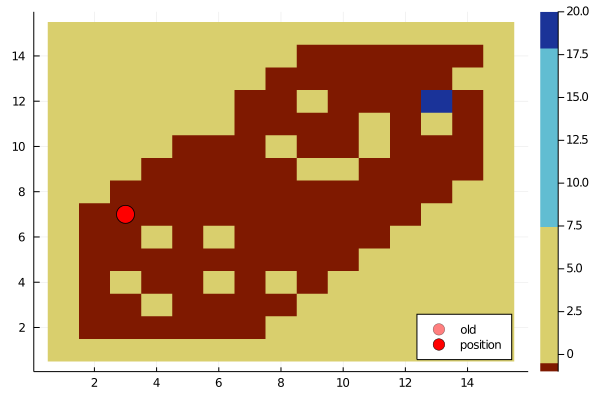

In [721]:
using Plots
grid=copy(testgrid.grid)
x,y=give_cartisian_posistion(testgrid.grid,agent1.old_position)

#grid[agent1.position]=-10
heatmap((grid),fill=true,levels=[-2,-1,0,1,10],color=cgrad(:roma, [0.02, 0.4, 0.9,1], rev = false, categorical = true))
scatter!([x],[y],markersize=10,color=:red,alpha=0.5,label="old")
x,y=give_cartisian_posistion(testgrid.grid,agent1.position)
scatter!([x],[y],markersize=10,color=:red,key=:bottomright,label="position")


In [511]:
5 % 3

2

In [512]:
mean(sample([1,2,3],Weights([0.1,0.5,0.4]),1000)),0.1+1+3*0.4

(2.262, 2.3000000000000003)

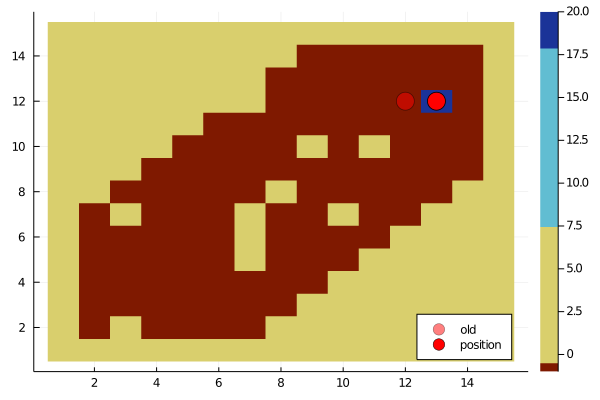

In [715]:
#action=3# 1 = down , 2 = right, 3 = up, 4 = left
action=choose_action(ql,agent1)
found,reward = move_actor(testgrid, agent1,action) 
grid=copy(testgrid.grid)
x,y=give_cartisian_posistion(testgrid.grid,agent1.old_position)

#grid[agent1.position]=-10
heatmap((grid),fill=true,levels=[-2,-1,0,1,10],color=cgrad(:roma, [0.02, 0.4, 0.9,1], rev = false, categorical = true))
scatter!([x],[y],markersize=10,color=:red,alpha=0.5,label="old")
x,y=give_cartisian_posistion(testgrid.grid,agent1.position)
scatter!([x],[y],markersize=10,color=:red,key=:bottomright,label="position")

┌ Info: Saved animation to 
│   fn = /Users/oskar/Desktop/PICKLE.gif
└ @ Plots /Users/oskar/.julia/packages/Plots/vsE7b/src/animation.jl:104


Plots.AnimatedGif("/Users/oskar/Desktop/PICKLE.gif")
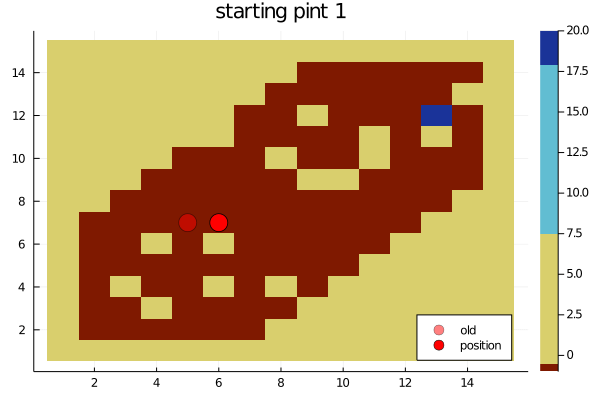

In [725]:
agent1=start_agent(testgrid)
grid=copy(testgrid.grid)
triels=100
foundcount=1
anim = @animate for trile in 1:triels
    
    action=choose_action(ql,agent1)
    found,reward = move_actor(testgrid, agent1,action) 
    x,y=give_cartisian_posistion(testgrid.grid,agent1.old_position)
    #grid[agent1.position]=-10
    heatmap((grid),fill=true,levels=[-2,-1,0,1,10],color=cgrad(:roma, [0.02, 0.4, 0.9,1], rev = false, categorical = true))
    scatter!([x],[y],markersize=10,color=:red,alpha=0.5,label="old")
    x,y=give_cartisian_posistion(testgrid.grid,agent1.position)
    scatter!([x],[y],markersize=10,color=:red,key=:bottomright,label="position",title="starting pint $(foundcount)")
    if found
        agent1=start_agent(testgrid)
        foundcount+=1
    end
    
end
 
gif(anim, "/Users/oskar/Desktop/PICKLE.gif", fps = 4)

In [613]:
col1=cgrad(:matter, [0.1, 0.2, 0.9], rev = false, categorical = true)

In [599]:
update_System(ql,agent1,action,reward)

1.0

In [724]:
rounds=10000
last_round=0
foundcounter =0
totalrards=Vector{Int64}()
roundcounter=Vector{Int64}()
for round in 1:rounds
    action=choose_action(ql,agent1)
    found,reward = move_actor(testgrid, agent1,action)
    update_System(ql,agent1,action,reward)
    if found
        foundcounter+=1
        append!(totalrards,agent1.totalreward)
        append!(roundcounter,round-last_round)
        if (foundcounter%10 == 0)
            println("mean last found time  $(mean(roundcounter))  with mean reward $(mean(totalrards))")
            totalrards=Vector{Int64}()
            roundcounter=Vector{Int64}()
        end
        last_round=round
        agent1=start_agent(testgrid)
        
    end
end

        

mean last found time  15.6  with mean reward 4.1
mean last found time  12.1  with mean reward 8.9
mean last found time  15.9  with mean reward 5.1
mean last found time  12.5  with mean reward 8.5
mean last found time  8.9  with mean reward 12.1
mean last found time  9.8  with mean reward 11.2
mean last found time  14.5  with mean reward 6.5
mean last found time  10.2  with mean reward 10.8
mean last found time  8.7  with mean reward 12.3
mean last found time  11.7  with mean reward 9.3
mean last found time  13.1  with mean reward 7.9
mean last found time  14.9  with mean reward 6.1
mean last found time  12.8  with mean reward 8.2
mean last found time  9.9  with mean reward 11.1
mean last found time  11.5  with mean reward 9.5
mean last found time  16.1  with mean reward 4.9
mean last found time  13.8  with mean reward 7.2
mean last found time  9.4  with mean reward 11.6
mean last found time  13.3  with mean reward 7.7
mean last found time  7.2  with mean reward 13.8
mean last found tim

In [489]:
point=give_grid_posistion(testgrid.grid,(6,7))
ql.q_table[:,point],testgrid.grid[point]

([0.0, 0.0, 0.0, 0.0], 20)

In [544]:
point=give_grid_posistion(testgrid.grid,(6,10)),give_cartisian_posistion(testgrid.grid,point)

60

In [545]:
give_cartisian_posistion(testgrid.grid,point)

(7, 60)

In [478]:
testgrid.actions

4-element Array{Int64,1}:
  -1
  10
   1
 -10

In [137]:
action=choose_action(ql,agent1)
println(action)
    found,reward = move_actor(testgrid, agent1,action)
println(found,reward)
    update_System(ql,agent1,action,reward)
found,reward 


2
false-1


(false, -1)

In [138]:
move_actor(testgrid, agent1,action)

(false, -1)

In [128]:
agent1,testgrid.actions[action]

(agent(18, 19, -38), -1)

In [105]:
test[1,:].=0
test[size[1],:].=0
test[:,1].=0
test[:,size[2]].=0

10-element view(::Array{Int8,2}, :, 8) with eltype Int8:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [109]:
rand(2:10)

10

In [5]:
walls=[]
for wall in walls
    println(give_grid_posistion(test,wall))
end


In [55]:
test2=rand(Int,(10000,10000));

In [56]:
sum1=0
@time for ii in 1:length(test2[1,:])
    for jj in 1:length(test2[:,1])
        sum1 +=test2[jj,ii]
    end
end


 13.466322 seconds (489.86 M allocations: 9.535 GiB, 11.75% gc time)


In [57]:
sum1=0
@time for jj in 1:length(test2[:,1])
        for ii in 1:length(test2[1,:])
            sum1 +=test2[jj,ii]
    end
end

 18.923532 seconds (489.86 M allocations: 9.535 GiB, 6.58% gc time)


In [58]:
test2=rand(Int8,(4,4))

4×4 Array{Int8,2}:
   7    2   -64  -124
 -90   19  -116    54
 -86   93     6   -18
  30  -43    67  -103

In [61]:
test2[2,1],test2[2]

(-90, -90)